<a href="https://colab.research.google.com/github/Andriansyah2501/Proyek-Klasifikasi-Gambar/blob/main/klasifikasi_gambar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 4.6 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
db-dtypes 1.4.3 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.
google-cloud-bigquery 3.32.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [3]:
# Library yang sering digunakan
import os, shutil
import random
from random import sample
import shutil
from shutil import copyfile
import pathlib
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm as tq
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

# Libraries untuk pemrosesan data gambar
from PIL import Image

# Libraries untuk pembangunan model
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import tensorflow as tf
from tensorflow.keras import Model, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop, SGD
from tensorflow.keras.layers import InputLayer, Conv2D, SeparableConv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau
import tensorflowjs as tfjs
from keras.layers import TFSMLayer
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)



In [8]:
# Download latest version
path = kagglehub.dataset_download("lyensoetanto/vehicle-images-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/vehicle-images-dataset


In [9]:
# Melihat isi folder dataset
dataset_dir = "/kaggle/input/vehicle-images-dataset"
print("Folder dalam dataset:", os.listdir(dataset_dir))

Folder dalam dataset: ['Van', 'Truck', 'Big Truck', 'Multi Purpose Vehicle', 'Sedan', 'Sport Utility Vehicle', 'City Car']


In [10]:
# Count total number of images, excluding non-directory files
total = sum(len(os.listdir(os.path.join(dataset_dir, label)))
 for label in os.listdir(dataset_dir)
 if os.path.isdir(os.path.join(dataset_dir, label)))

print(f"\nTotal dataset: {total}")


Total dataset: 15645


In [11]:
train_dir = "/kaggle/working/kendaraan-split/train"
val_dir = "/kaggle/working/kendaraan-split/val"
test_dir = "/kaggle/working/kendaraan-split/test"

# Direktori baru untuk dataset gabungan
combined_dir = "/kaggle/working/kendaraan"

In [12]:
def split_dataset(source_dir, train_dir, val_dir, test_dir, split_ratio=(0.7, 0.15, 0.15)):
 # Check if the target directories already exist
 if os.path.exists(train_dir) and os.path.exists(val_dir) and os.path.exists(test_dir):
     print("Target directories already exist. No action performed.")
     return # Exit the function if the directories already exist

 # Create the target directories if they don't exist
 os.makedirs(train_dir, exist_ok=True)
 os.makedirs(val_dir, exist_ok=True)
 os.makedirs(test_dir, exist_ok=True)

 labels = os.listdir(source_dir)

 for label in labels:
     label_dir_source = os.path.join(source_dir, label)
     if os.path.isdir(label_dir_source):
         img_paths = [os.path.join(label_dir_source, fname) for fname in os.listdir(label_dir_source)]

     # Split the dataset into train, validation, and test sets
     train_files, temp_files = train_test_split(img_paths, train_size=split_ratio[0], shuffle=True)
     val_files, test_files = train_test_split(temp_files, test_size=split_ratio[2]/(split_ratio[1] + split_ratio[2]))

     for path_set, target_dir in zip([train_files, val_files, test_files], [train_dir, val_dir, test_dir]):
         label_dir_target = os.path.join(target_dir, label)

         # Create label-specific directories if they don't exist
         os.makedirs(label_dir_target, exist_ok=True)

         # Copy the files into the respective directories
         for file in path_set:
             shutil.copy(file, label_dir_target)

# Jalankan fungsi split
split_dataset(dataset_dir, train_dir, val_dir, test_dir)

In [13]:
# Buat direktori baru untuk dataset gabungan
if not os.path.exists(combined_dir):
    os.makedirs(combined_dir, exist_ok=True)

    # Salin file dan folder dari train
    for category in os.listdir(train_dir):
        category_dir = os.path.join(train_dir, category)
        if os.path.isdir(category_dir):
            shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

    # Salin file dan folder dari test
    for category in os.listdir(test_dir):
        category_dir = os.path.join(test_dir, category)
        if os.path.isdir(category_dir):
            shutil.copytree(category_dir, os.path.join(combined_dir, category), dirs_exist_ok=True)

    # Print the path to the dataset files
    print(f"Dataset copied to: {combined_dir}")
else:
    print(f"Dataset already exists at: {combined_dir}")

Dataset copied to: /kaggle/working/kendaraan


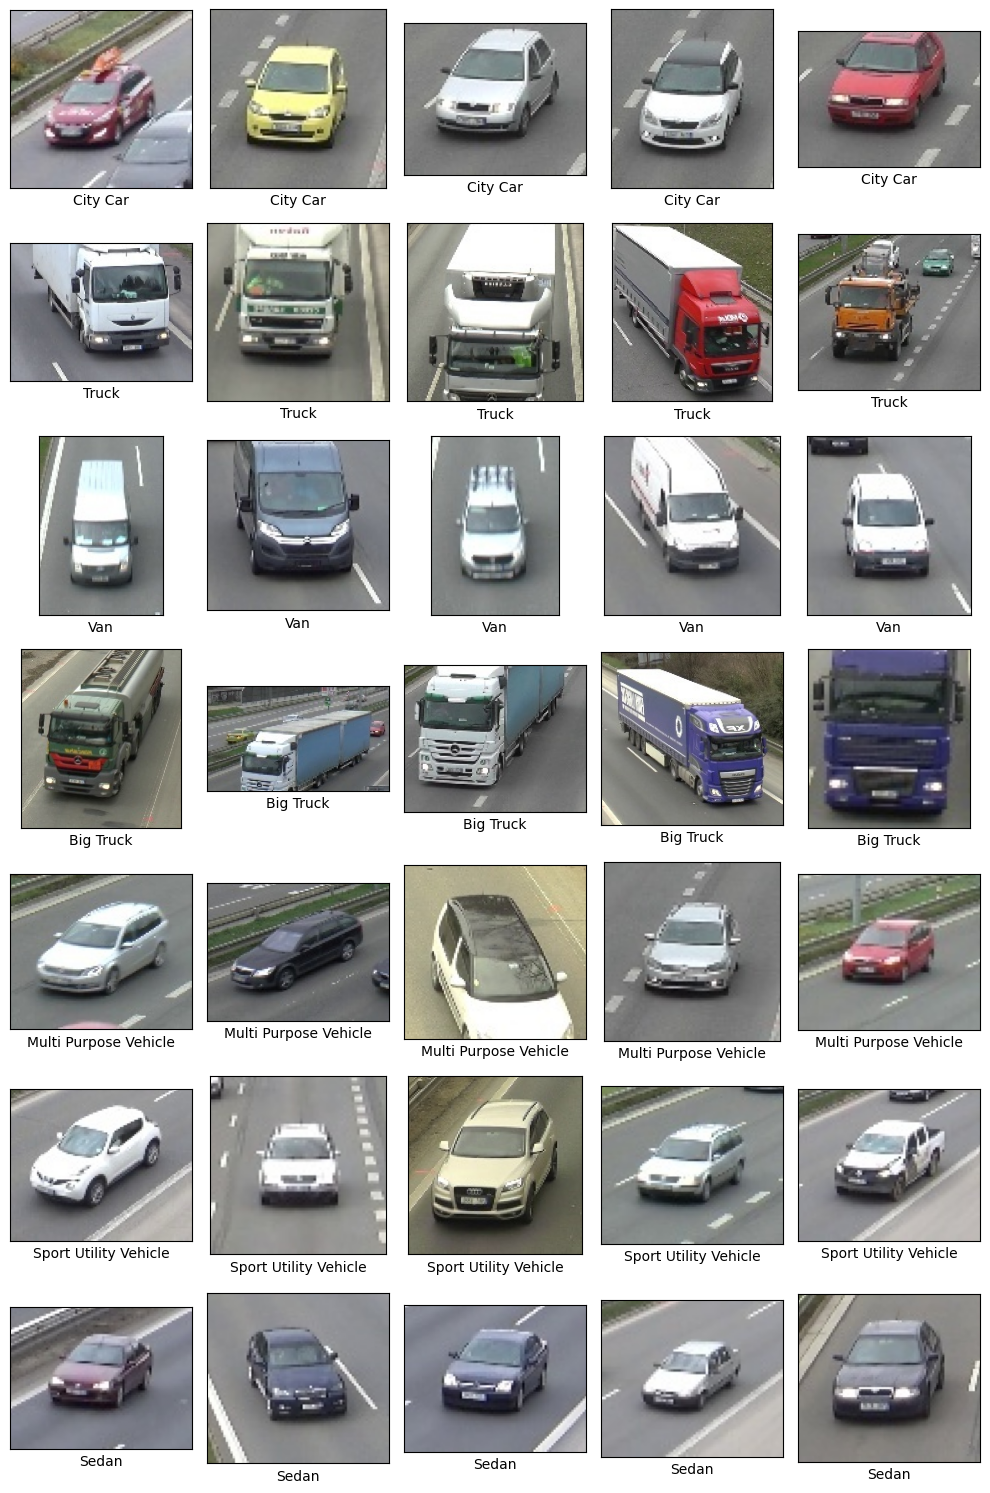

In [14]:
# Membuat kamus yang menyimpan gambar untuk setiap kelas dalam data
kendaraan_image = {}

# Tentukan path sumber train
path = combined_dir  # Ganti dengan path yang sesuai

for i in os.listdir(combined_dir):
    kendaraan_image[i] = os.listdir(os.path.join(combined_dir, i))

# Menampilkan secara acak 5 gambar di bawah setiap kelas dari data latih
fig, axs = plt.subplots(len(kendaraan_image.keys()), 5, figsize=(10, 15))

for i, class_name in enumerate(os.listdir(combined_dir)):
    images = np.random.choice(kendaraan_image[class_name], 5, replace=False)

    for j, image_name in enumerate(images):
        img_path = os.path.join(combined_dir, class_name, image_name)
        img = Image.open(img_path)  # Jangan mengubah ke grayscale

        # Normalisasi gambar (piksel antara 0 dan 1)
        img_array = np.array(img) / 255.0

        # Tampilkan gambar yang sudah dinormalisasi dengan warna asli (RGB)
        axs[i, j].imshow(img_array)
        axs[i, j].set(xlabel=class_name, xticks=[], yticks=[])

fig.tight_layout()

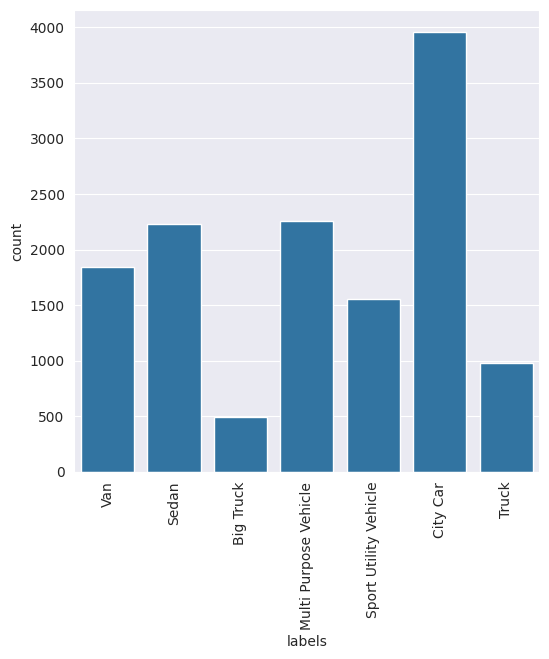

In [10]:
# Create lists to store file names, labels, and full paths
file_name = []
labels = []
full_path = []

# Walk through the food directory to get file names, paths, and labels
for path, subdirs, files in os.walk(combined_dir):
    if '.ipynb_checkpoints' in path:
        continue  # Skip checkpoint directories
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])  # Get the last part of the path as the label
        file_name.append(name)

# Create a DataFrame with the file details
distribution_train = pd.DataFrame({"path": full_path, 'file_name': file_name, "labels": labels})

# Plot the distribution of images in each category
plt.figure(figsize=(6,6))
sns.set_style("darkgrid")
sns.countplot(x='labels', data=distribution_train)  # Correct usage of countplot with 'data'

# Show the plot
plt.xticks(rotation=90)  # Rotate labels if necessary
plt.show()

In [11]:
file_name = []
labels = []
full_path = []
for path, subdirs, files in os.walk(combined_dir):
    for name in files:
        full_path.append(os.path.join(path, name))
        labels.append(path.split('/')[-1])
        file_name.append(name)

# Memasukkan variabel yang sudah dikumpulkan pada looping di atas menjadi sebuah dataframe agar rapi
df = pd.DataFrame({"path":full_path,'file_name':file_name,"labels":labels})
# Melihat jumlah data gambar pada masing-masing label
df.groupby(['labels']).size()

,0
labels,
Big Truck,490
City Car,3958
Multi Purpose Vehicle,2252
Sedan,2226
Sport Utility Vehicle,1552
Truck,978
Van,1842


#SPLIT DATASET

In [15]:
train_datagen = ImageDataGenerator(
                rescale=1.0/255,
                rotation_range=20,
                zoom_range=0.2,
                shear_range=0.2,
                horizontal_flip=True)

val_test_datagen = ImageDataGenerator(rescale=1.0/255)

train_generator = train_datagen.flow_from_directory(
                    train_dir,
                    target_size=(150, 150),
                    batch_size=64,
                    class_mode='categorical'
)

val_generator = val_test_datagen.flow_from_directory(
                val_dir,
                target_size=(150, 150),
                batch_size=64,
                class_mode='categorical')
test_generator = val_test_datagen.flow_from_directory(
                test_dir,
                target_size=(150, 150),
                batch_size=64,
                class_mode='categorical',
                shuffle=False)

Found 10948 images belonging to 7 classes.
Found 2347 images belonging to 7 classes.
Found 2350 images belonging to 7 classes.


In [16]:
# Define the MirroredStrategy for multi-GPU
strategy = tf.distribute.MirroredStrategy()

# Print out the number of GPUs being used
print(f'Number of devices: {strategy.num_replicas_in_sync}')

# Now, compile the model and fit it within the strategy scope
with strategy.scope():
    model = Sequential()

    model.add(Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(150, 150, 3)))
    model.add(MaxPool2D((2,2)))

    model.add(Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(MaxPool2D((2,2)))

    model.add(layers.Conv2D(128, (3,3), activation='relu'))
    model.add(layers.MaxPooling2D((2,2)))


    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    # Output Layer for multi-class classification
    model.add(Dense(len(train_generator.class_indices), activation='softmax'))  # Softmax for multi-class classification

    model.compile(optimizer='adam',loss='categorical_crossentropy', metrics=['accuracy'])
    model.summary()

Number of devices: 1


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 35, 35, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 17, 17, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 36992)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,837,063 (18.45 MB)

 Trainable params: 4,837,063 (18.45 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>=0.95):
      print("\nAkurasi telah mencapai >=95%!")
      self.model.stop_training = True
callbacks = myCallback()

In [18]:
history = model.fit(
        train_generator,
        validation_data=val_generator,
        epochs=30,
        batch_size=128,
        callbacks=[callbacks],
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 75s 404ms/step - accuracy: 0.2482 - loss: 1.8884 - val_accuracy: 0.2978 - val_loss: 1.7292
Epoch 2/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 72s 417ms/step - accuracy: 0.2905 - loss: 1.7078 - val_accuracy: 0.3068 - val_loss: 1.6205
Epoch 3/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 70s 409ms/step - accuracy: 0.2989 - loss: 1.6572 - val_accuracy: 0.4056 - val_loss: 1.5190
Epoch 4/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 70s 407ms/step - accuracy: 0.3565 - loss: 1.5832 - val_accuracy: 0.4214 - val_loss: 1.4224
Epoch 5/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 71s 410ms/step - accuracy: 0.3719 - loss: 1.5252 - val_accuracy: 0.4299 - val_loss: 1.4058
Epoch 6/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 69s 402ms/step - accuracy: 0.4025 - loss: 1.4564 - val_accuracy: 0.4542 - val_loss: 1.3256
Epoch 7/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 71s 410ms/step - accuracy: 0.4043 - loss: 1.4159 - val_accuracy: 0.4380 - val_loss: 1.2907
Epoch 8/30
172/172 ━━━━━━━━━━━━━━━━━━━━ 69s 401ms/step - accuracy: 0.4028 - loss: 1

In [19]:
# Evaluasi pada test set
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)# Evaluasi pada test set
test_loss, test_acc = model.evaluate(test_generator)
print("Test Accuracy:", test_acc)

37/37 ━━━━━━━━━━━━━━━━━━━━ 3s 69ms/step - accuracy: 0.5405 - loss: 1.2688
Test Accuracy: 0.4668084979057312
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 52ms/step - accuracy: 0.5405 - loss: 1.2688
Test Accuracy: 0.4668084979057312


# **EVALUASI DAN VISUALISASI**

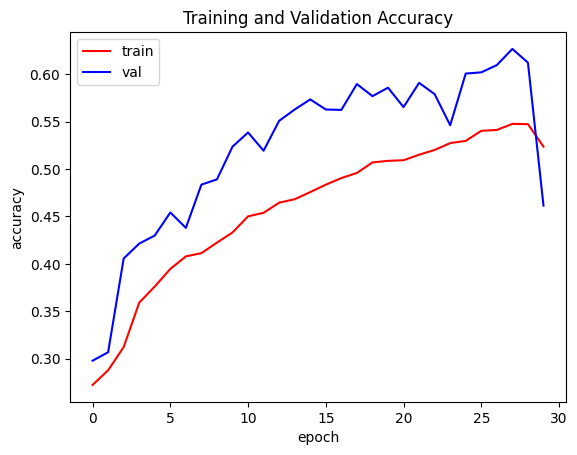

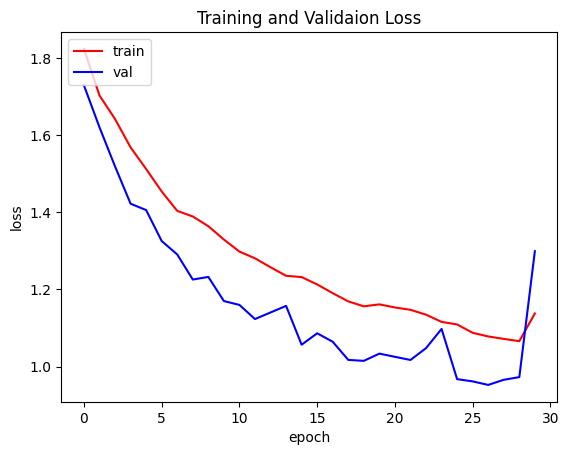

In [20]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r')
plt.plot(epochs, val_acc, 'b')
plt.title('Training and Validation Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.title('Training and Validaion Loss')
plt.show()

37/37 ━━━━━━━━━━━━━━━━━━━━ 5s 119ms/step
Classification Report:
                       precision    recall  f1-score   support

            Big Truck       0.00      0.00      0.00        87
             City Car       0.40      0.93      0.56       699
Multi Purpose Vehicle       0.45      0.01      0.02       398
                Sedan       0.00      0.00      0.00       393
Sport Utility Vehicle       0.67      0.32      0.43       274
                Truck       0.50      0.92      0.65       173
                  Van       0.70      0.60      0.65       326

             accuracy                           0.47      2350
            macro avg       0.39      0.40      0.33      2350
         weighted avg       0.41      0.47      0.36      2350



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


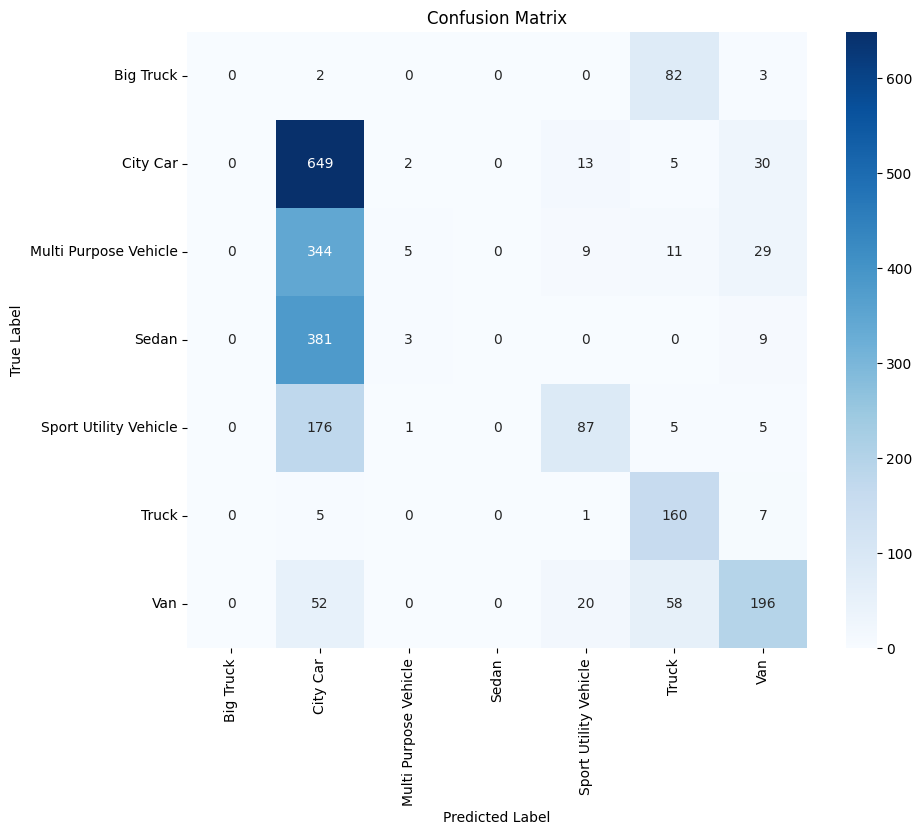

In [21]:
# Prediksi data uji
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

# Label asli
y_true = test_generator.classes

# Nama label (kelas)
labels = list(train_generator.class_indices.keys())

# Classification Report
print("Classification Report:")
print(classification_report(y_true, y_pred_classes, target_names=labels))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


# **KONVERSI**

In [22]:
model.save("model.h5")

In [23]:
model = tf.keras.models.load_model('/kaggle/working/model.h5')

tfjs_dir = '/kaggle/working/tfjs_model'
tfjs.converters.save_keras_model(model, tfjs_dir)

print(f"Model berhasil dikonversi ke TFJS dan disimpan di: {tfjs_dir}")

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/kaggle/working/model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)